<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>


<br>

# <font color="#76b900" style="text-align:center;">**Notebook 6:** 內嵌模型(Embedding Models)與語意分析推理(Semantic Reasoning)</font>


在前一個 notebook 中，我們將努力擴展到大型文件領域，並學會如何將相同的技術應用於龐大的相關內容基礎！過程中，我們也注意到一些挑戰------特別是在即時動態(in-flight)詮釋方面------這些是現有技術仍無法解決的。本 notebook 將帶領我們轉向另一種方法以協助達成這個目標：**內嵌模型(Embedding Models)**。


<br>

### **學習目標：**


-   熟悉內嵌(Embedding)------將單詞、片語或文件轉換為數值向量的方式------以及它們如何讓深度學習模型處理語意意義。

-   學會如何在大規模文件處理中應用這些內嵌模型(Embedding Models)，強化現有的文件摘要與知識擷取方法。


<br>

### **值得思考的問題：**


-   內嵌(Embedding)如何幫助我們更深入理解文件分塊(Chunking)，尤其是在遇到不一致或文字(Text)轉換問題時？

-   我們如何在細節與運算效率間取得平衡？能否用 LLM 來重述或標準化您的查詢，或進行專業化微調？

-   內嵌模型(Embedding Models)如何補足我們之前開發的 Running State Chain 與知識庫？（下一本 notebook 主題）


<br>

### **環境設置：**



In [1]:
## Necessary for Colab, not necessary for course environment
# %pip install -qq langchain langchain-nvidia-ai-endpoints gradio
# %pip install -qq arxiv pymupdf

# import os
# os.environ["NVIDIA_API_KEY"] = "nvapi-..."

from functools import partial
from rich.console import Console
from rich.style import Style
from rich.theme import Theme

console = Console()
base_style = Style(color="#76B900", bold=True)
pprint = partial(console.print, style=base_style)



<br>

## **第一部分：** 內嵌模型(Embedding Models)再認識


本節將回顧自然語言處理與深度學習相關的想法，釐清什麼是內嵌模型(Embedding Models)，以及它們與我們目前所用工具的關聯。

<br>

### **理解隱向量(Latent Embeddings)**


隱向量(Latent Embeddings)在深度學習網路中扮演中介角色，連結輸入與輸出。例如，假設我們有一個用於分類 [**MNIST 手寫數字**](https://en.wikipedia.org/wiki/MNIST_database) 的兩層輕量網路。此時，輸入與輸出分別可能是攤平成一維的影像與 one-hot 機率向量。第一層產生的值即為該影像的隱向量(Latent Embeddings)，這些向量經過最佳化，成為最終層可用的有用表徵。這些語意豐富的內嵌(Esemantically rich embeddingsmbedding)雖然不見得能被人類直接解讀，但其原始向量(raw vector)特性可被有效應用。



<br>


### **詞彙內嵌(Word Embeddings)：語言模型的基石**


詞彙內嵌(Word Embeddings)是單一單詞的高維向量表徵，構成深層語言模型的基礎。這些內嵌(Embedding)是透過端到端管線(Pipeline)中的最佳化過程產生，並針對特定任務設計。[**Word2vec**](https://en.wikipedia.org/wiki/Word2vec) 是其中一個著名的獨立範例。實務上，語言模型的 $v$-token 詞彙中的一個 token 會從 token 索引對應到 $d$ 維的 token 內嵌(Embedding)：

$$\text{Token Index} \in \{0, 1, \cdots, v-1\} \to \text{Token Embedding} \in \mathbb{R}^{d}$$

對於長度為 $n$ 的 token 序列，這樣的對應會延伸到整個序列：

$$\text{Token Sequence} \in \{0, 1, \cdots, v-1\}^{v} \to \text{Embedding Sequence} \in \mathbb{R}^{n\times d}$$



<br>


### **句子/文件內嵌(Sentence/Document Embeddings)：捕捉脈絡資訊(Context)與語意**


處理句子或完整文件時，內嵌(Embedding)在捕捉脈絡資訊(Context)、語意與各元素間互動上扮演關鍵角色。幾乎所有大型語言模型都使用**類 Transformer 架構**來產生這些句子/文件內嵌(Embedding)。Transformer 允許網路在優化問題上，同時傳遞逐 token 與整體序列層級的資訊。

<br>

### **解碼器模型(Decoder Models)於語言生成**


解碼器模型常用於聊天機器人與語言生成任務，會將一連串 token 作為輸入，將這些 token 內嵌(Embedding)為隱向量序列，並以單向分析推理(Reasoning)聚焦於輸出序列的特定部分。模型會從這個語意密集的點預測下一個 token：


$$$$
$$\text{[ Next-Token Generation ]}$$
$$\text{Embedding Sequence} \in \mathbb{R}^{n\times d} \to \text{Latent Sequence} \in \mathbb{R}^{n\times d}$$
$$(\text{Latent Sequence})[\text{last entry}] \in \mathbb{R}^{d} \to \text{Token Prediction} \in \mathbb{R}^{v}$$
$$$$

這個過程會持續進行，將 token 預測從向量轉為實際 token，並依序累積，直到達到終止條件（如長度限制或停止 token）。

$$$$
$$\text{[ Autoregressive Generation ]}$$
$$(\text{Original + Predicted Embedding Sequence}) \in \mathbb{R}^{(n+1)\times e} \to \text{Token Prediction} \in \mathbb{R}^{v}$$
$$\vdots$$
$$(\text{Original + Predicted Embedding Sequence}) \in \mathbb{R}^{(n+m)\times e} \to \text{Token Prediction} \in \mathbb{R}^{v}$$
$$$$
<br>

### **編碼器模型(Encoder Models)於序列編碼**


編碼器模型採用雙向架構，適用於與解碼器模型不同的任務，特別是在 token 或序列預測方面。令 $c$ 為類別數或回歸值數：

$$$$
$$\text{[ Per-Token Prediction ]}$$
$$\text{Embedding Sequence} \in \mathbb{R}^{n\times d} \to \text{Latent Sequence} \in \mathbb{R}^{n\times d} \to \text{Per-Token Predictions} \in \mathbb{R}^{n\times c}$$

$$$$
$$\text{[ Full-Sequence Prediction ]}$$
$$\text{Embedding Sequence} \in \mathbb{R}^{n\times d} \to \text{Latent Sequence} \in \mathbb{R}^{n\times d}$$
$$(\text{Latent Sequence})[\text{0th entry}] \in \mathbb{R}^{d} \to \text{Sequence Prediction} \in \mathbb{R}^{c}$$

<br>

> <img src="https://dli-lms.s3.amazonaws.com/assets/s-fx-15-v1/imgs/encoder-decoder.png" width=1200px/>
<!-- > <img src="https://drive.google.com/uc?export=view&id=1lhswkAgb5TlDxezg3qDNZQKbOMGFz7H5" width=1200px/> -->





<br>

## **第二部分：** 使用 NVIDIAEmbeddings 模型


在本 notebook 中，我們將使用一個內嵌模型(Embedding Model)，該模型有兩條路徑：短格式「查詢」(query)與長格式「文件」(passage)。我們將學習如何正確分析推理(Reasoning)其輸出，並將其用於補足我們現有的 LLM 工具組！

我們將再次利用 AI 基礎模型端點(Endpoints)與其在 LangChain 的整合！本節內容與 [**官方 NVIDIAEmbeddings 文件**](https://python.langchain.com/docs/integrations/text_embedding/nvidia_ai_endpoints) 十分相似。

截至目前，這項任務推薦的模型為 [**NVIDIA Retrieval QA Embedding model**](https://build.nvidia.com/nvidia/embed-qa-4)，這是經過法律審查的 [**E5-Large embedding model**](https://huggingface.co/intfloat/e5-large) 微調版本，標記為 `nvolveqa_40k`。名稱可能會變動，請查閱最新清單以確認推薦模型。

<br>

### **辨識我們的模型**


在可用模型中，您應能找到適合區分人類可讀段落的內嵌模型(Embedding Model)。確認端點(Endpoint)後，建立 `NVIDIAEmbeddings` 實例連接，並檢查其可用方法。



In [2]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

[m for m in NVIDIAEmbeddings.get_available_models() if "embed" in m.id]

/usr/local/lib/python3.11/site-packages/langchain_nvidia_ai_endpoints/_common.py:237: UserWarning: Default model is set as: 01-ai/yi-large. 
Set model using model parameter. 
To get available models use available_models property.
  warnings.warn(


[Model(id='nvidia/embed-qa-4', model_type='embedding', client='NVIDIAEmbeddings', endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='nvidia/llama-3.2-nemoretriever-1b-vlm-embed-v1', model_type=None, client=None, endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='nvidia/llama-3.2-nv-embedqa-1b-v1', model_type='embedding', client='NVIDIAEmbeddings', endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='nvidia/llama-3.2-nv-embedqa-1b-v2', model_type='embedding', client='NVIDIAEmbeddings', endpoint=None, aliases=None, supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='nvidia/nv-embed-v1', model_type='embedding', client='NVIDIAEmbeddings', endpoint=None, aliases=['ai-nv-embed-v1'], supports_tools=False, supports_structured_output=False, base_model=None),
 Model(id='nvidia/nv

In [3]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA, NVIDIAEmbeddings

# NVIDIAEmbeddings.get_available_models()
# embedder = NVIDIAEmbeddings(model="nvidia/nv-embedqa-mistral-7b-v2")
# embedder = NVIDIAEmbeddings(model="nvidia/nv-embedqa-e5-v5")
# embedder = NVIDIAEmbeddings(model="nvidia/embed-qa-4")
# embedder = NVIDIAEmbeddings(model="snowflake/arctic-embed-l")
embedder = NVIDIAEmbeddings(model="nvidia/nv-embed-v1")

# ChatNVIDIA.get_available_models()
instruct_llm = ChatNVIDIA(model="mistralai/mixtral-8x7b-instruct-v0.1")

### **使用 API 最佳化資料內嵌(Embedding)**


利用 LangChain 的 `Embeddings` 介面與 NVIDIAEmbeddings 模型，我們聚焦於同時內嵌(Embedding) **查詢(queries)** 與 **文件(documents)** 兩條路徑。這種區分對於檢索(Retrieval)應用的資料處理與利用方式至關重要：



<br>

#### **查詢內嵌(Query Embedding)**

-   **目的**：設計用於較短或類似問題的內容，如簡單陳述或問題。
-   **方法**：使用 `embed_query` 單獨內嵌(Embedding)每個查詢。
-   **在檢索(Retrieval)中的角色**：作為「key」以便在文件檢索(Retrieval)框架中搜尋。
-   **使用模式**：動態內嵌(Embedding)，即時與已預處理的文件內嵌(Embedding)集合比對。

<br>

#### **文件內嵌(Document Embedding)**


-   **目的**：設計用於較長或回應型內容，包括文件分塊(Chunking)或段落。
-   **方法**：使用 `embed_documents` 批次處理文件。
-   **在檢索(Retrieval)中的角色**：作為「value」建立可搜尋內容。
-   **使用模式**：通常於前處理階段大量內嵌(Embedding)，建立未來查詢用的文件內嵌(Embedding)資料庫。

<br>

#### **底層相似性與實務應用**


雖然應用不同，這兩個過程本質上都將文字(Text)內容轉換為語意豐富的向量表徵。選擇 `embed_query` 或 `embed_documents` 取決於內容性質及其在檢索(Retrieval)系統中的用途。

<br>

#### **使用範例「查詢」與「文件」探索**

讓我們用一組範例查詢與文件來啟動探索，理解這些流程的實際運作。這些範例特意選擇，突顯有趣特性並展示內嵌模型(Embedding Model)在一般文字(Text)分析推理(Reasoning)上的能力。






In [4]:
# Example queries and documents
queries = [
    "What's the weather like in Rocky Mountains?",
    "What kinds of food is Italy known for?",
    "What's my name? I bet you don't remember...",
    "What's the point of life anyways?",
    "The point of life is to have fun :D"
]

documents = [
    "Komchatka's weather is cold, with long, severe winters.",
    "Italy is famous for pasta, pizza, gelato, and espresso.",
    "I can't recall personal names, only provide information.",
    "Life's purpose varies, often seen as personal fulfillment.",
    "Enjoying life's moments is indeed a wonderful approach.",
]


我們可以透過查詢或文件路徑將這些片段編碼。由於方法簽名(method signatures)因用途而異，語法略有不同：

In [5]:
%%time
# Embedding the queries
q_embeddings = [embedder.embed_query(query) for query in queries]

# Embedding the documents
d_embeddings = embedder.embed_documents(documents)

CPU times: user 45.2 ms, sys: 4.51 ms, total: 49.7 ms
Wall time: 2.28 s





取得內嵌(Embedding)後，我們可以簡單比對相似度，觀察在檢索(Retrieval)任務中哪些文件會被視為合理答案。當資料(Entries)準備好後，執行下方程式碼區塊以視覺化交叉相似度矩陣。

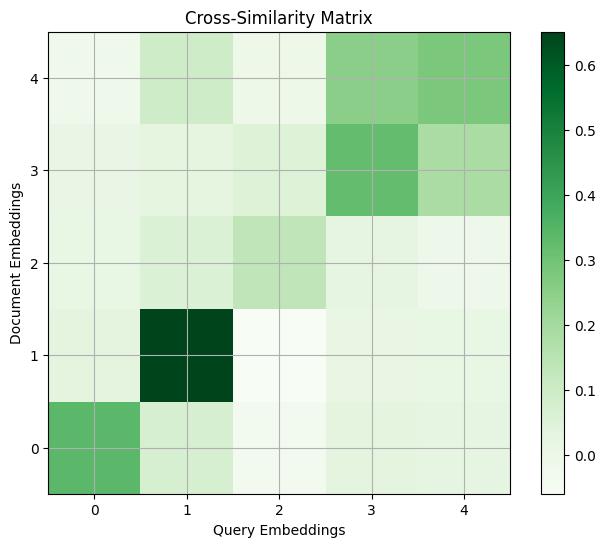

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def plot_cross_similarity_matrix(emb1, emb2):
    # Compute the similarity matrix between embeddings1 and embeddings2
    cross_similarity_matrix = cosine_similarity(np.array(emb1), np.array(emb2))

    # Plotting the cross-similarity matrix
    plt.imshow(cross_similarity_matrix, cmap='Greens', interpolation='nearest')
    plt.colorbar()
    plt.gca().invert_yaxis()
    plt.title("Cross-Similarity Matrix")
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_cross_similarity_matrix(q_embeddings, d_embeddings)
plt.xlabel("Query Embeddings")
plt.ylabel("Document Embeddings")
plt.show()

# queries = [
#     "What's the weather like in the Rocky Mountains?",
#     "What kinds of food is Italy known for?",
#     "What's my name? I bet you don't remember...",
#     "What's the point of life anyways?",
#     "The point of life is to have fun :D"]
# documents = [
#     "Komchatka's weather is cold, with long, severe winters.",
#     "Italy is famous for pasta, pizza, gelato, and espresso.",
#     "I can't recall personal names, only provide information.",
#     "Life's purpose varies, often seen as personal fulfillment.",
#     "Enjoying life's moments is indeed a wonderful approach."]


<br>

## **第三部分：[練習]** 合成的但更真實的範例


觀察哪些資料(Entries)可被視為良好的輸入/輸出對時，內嵌(Embedding)會有較高相似度。值得一提的是，根據編碼器模型收斂情況，查詢與文件路徑的結果可能有明顯差異，也可能沒有：

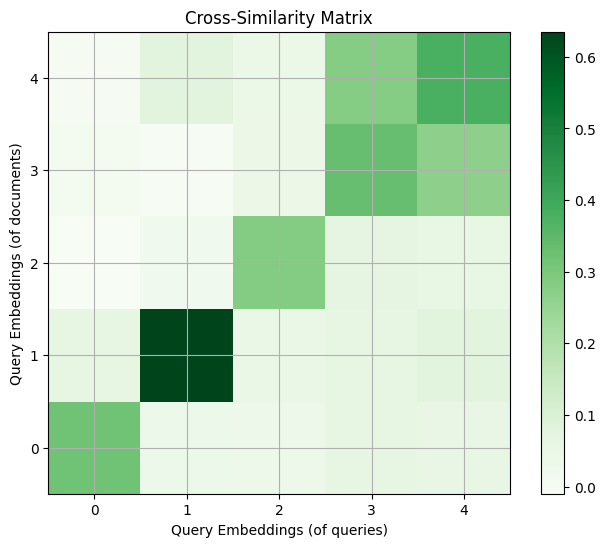

In [7]:
plt.figure(figsize=(8, 6))
plot_cross_similarity_matrix(
    q_embeddings,
    [embedder.embed_query(doc) for doc in documents]
)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Query Embeddings (of documents)")
plt.show()


擁有「雙編碼器(Bi-Encoder)」的一大實用性，在於一般來說即使輸入格式大幅改變，第二個編碼器仍可訓練成與第一個保持一致。為說明這點，我們可以將文件擴展為長篇的(long-form)版本，再進行同樣實驗。

In [8]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from operator import itemgetter

# embedder = NVIDIAEmbeddings(model="ai-embed-qa-4")
# instruct_llm = ChatNVIDIA(model="ai-mixtral-8x7b-instruct")

expound_prompt = ChatPromptTemplate.from_template(
    "Generate part of a longer story that could reasonably answer all"
    " of these questions somewhere in its contents: {questions}\n"
    " Make sure the passage only answers the following concretely: {q1}."
    " Give it some weird formatting, and try not to answer the others."
    " Do not include any commentary like 'Here is your response'"
)

###############################################################################################
## BEGIN TODO

expound_chain = (
    ## TODO: flesh out documents into a more verbose form by implementing the expound_chain 
    ##  which takes advantage of the prompt and llm provided above.
    {}
)

expound_chain = (
    {'q1' : itemgetter(0), 'questions' : itemgetter(1)} 
    | expound_prompt 
    | instruct_llm
    | StrOutputParser()
)

longer_docs = []
for i, q in enumerate(queries):
    ## TODO: Invoke the expound_chain pipeline as appropriate
    longer_doc = ""
    longer_doc = expound_chain.invoke([q, queries])
    pprint(f"\n\n[Query {i+1}]")
    print(q)
    pprint(f"\n\n[Document {i+1}]")
    print(longer_doc)
    pprint("-"*64)
    longer_docs += [longer_doc]

## END TODO
###############################################################################################

[Query 1]

What's the weather like in Rocky Mountains?


[Document 1]

Weather in the Rocky Mountains can be as unpredictable as a cat on a hot tin roof. One minute, the sun is shining bright, casting a warm, golden glow on the rugged mountain peaks. The next, the sky turns a menacing gray, and snow begins to fall, blanketing the ground in a fresh, white layer. It's a place where you can experience all four seasons in a single day, where the weather can change faster than a hiccup.

But despite its unpredictability, there's something undeniably beautiful about the Rocky Mountains' weather. The way the sunlight filters through the clouds, casting dancing shadows on the ground. The sound of rain pelting against the rocks, like a thousand tiny drumbeats. The stillness that falls after a snowstorm, broken only by the occasional howl of the wind. It's a reminder that nature is alive, constantly changing and evolving, and that there's beauty to be found in every moment, every shift, every storm.

So, what's the weather like in the Rocky Mountains, you ask? It's

----------------------------------------------------------------

[Query 2]

What kinds of food is Italy known for?


[Document 2]

We now turn our attention to the boot-shaped peninsula that is Italy. Ah, Italy – a land of beauty, history, and most importantly, food. The culinary traditions of this European gem are renowned the world over, and for good reason. From the sun-soaked vineyards of Tuscany to the bustling markets of Naples, the Italian people have perfected the art of creating dishes that are both simple and sublime.

One cannot discuss Italian cuisine without first mentioning pizza. Though it may seem cliche, pizza is a true Italian masterpiece. Made with a thin, crispy crust, tangy tomato sauce, and a variety of delicious toppings, pizza is the perfect food for any occasion. And let's not forget about the cheese – glorious, melted mozzarella that stretches for miles (or at least it seems that way).

Of course, pizza is just the tip of the iceberg when it comes to Italian cuisine. Pasta, another staple of the Italian diet, is a versatile and comforting food that can be dressed up or down depending on t

----------------------------------------------------------------

[Query 3]

What's my name? I bet you don't remember...


[Document 3]

"By the way," the strange, disembodied voice echoed through the cool air of the vast Rocky Mountain range, "what's my name? I bet you don't remember."

Suddenly, the weather shifted from a calm breeze to a fierce howling wind, as if the very mountains themselves were objecting to the interruption.

"All you need to know is that I am the keeper of secrets, the whisperer in the wind, and the one who guides you on your journey."

And with that, the voice faded away, leaving only the sound of the wind whistling through the towering peaks of the Rockies.

As for the food in Italy, and the meaning of life, those are questions best answered at another time, in another place.


----------------------------------------------------------------

[Query 4]

What's the point of life anyways?


[Document 4]

Life's Purpose Revealed:
Have you ever wondered about the meaning of it all? Why are we here? What's the point of life anyways? Well, search no more, for the answer has been revealed at last! Are you ready for it? Here it is:

"The point of life is to have fun :D"

That's right! The whole purpose of life is to enjoy yourself, to savor the experiences, and to make the most of your time on this strange and beautiful planet we call home.

But, wait, you might be thinking, "What about my name? Do you remember it?" or "What's the weather like in the Rocky Mountains?" or "What kinds of food is Italy known for?"

Well, those questions are interesting and all, but they're not quite as important as figuring out the meaning of life. Besides, you didn't ask me those questions, so I didn't feel obligated to answer them.

But, just in case you're curious, here's a little tidbit about the weather in the Rocky Mountains: it can be unpredictable, with sudden changes in temperature and precipitation. O

----------------------------------------------------------------

[Query 5]

The point of life is to have fun :D


[Document 5]

life's purpose: to have fun :D

"So, what's the deal with the meaning of life?" you ask, leaning back in your chair with a contemplative expression. The room is filled with a comfortable silence, punctuated only by the occasional clink of dishware and the distant hum of a coffee grinder.

I take a deep breath, savoring the rich aroma of freshly brewed coffee that fills the air. It's a small moment of joy, a fleeting pleasure that adds a touch of color to the tapestry of existence. And that, I realize, is the answer to your question.

"The point of life is to have fun," I say, my voice filled with a certainty that seems to surprise even me. "It's about finding joy in the little things, seeking out new experiences, and cherishing the connections we make with others."

A smile spreads across your face, and I can see the wheels turning in your mind as you consider my words. It's a simple answer, perhaps, but one that has the power to transform our lives in profound ways.

life's purpose: t

----------------------------------------------------------------



當您對長篇的(long-form)文件滿意後，請執行下方程式碼，比較內嵌(Embedding)結果。結果可能類似，但至少有某種數學最佳化的關聯，有助於在大規模檢索(Retrieval)中提升效果。這也會因雙編碼器(Bi-Encoder)模型而異，請留意。

一般來說，在推薦的使用情境(advertised use case)下， 預設應選用相反(opposite)的編碼器，若比較的內容形式與型態接近，則可考慮使用相同編碼器。本次測試模型的兩種選項結果差異不大，但仍值得注意。

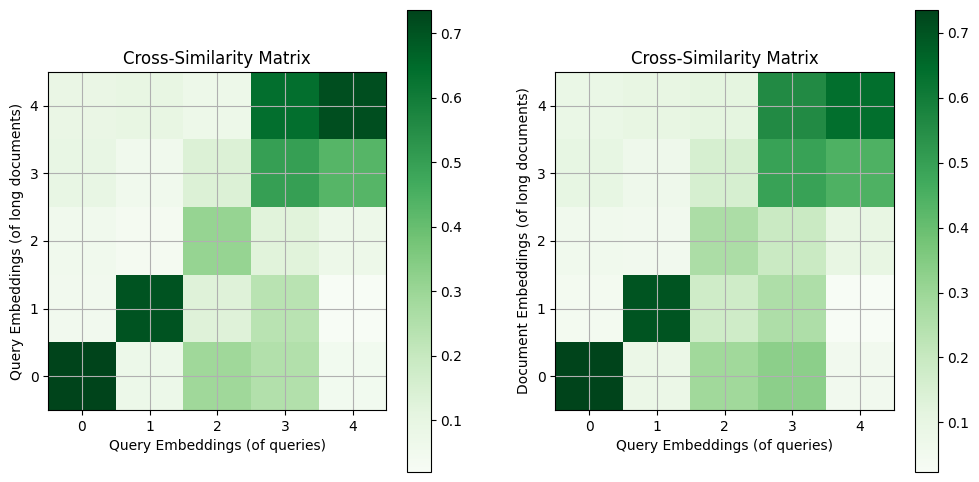

In [9]:
## At the time of writing, our embedding model supports up to 2048 tokens...
longer_docs_cut = [doc[:2048] for doc in longer_docs]

q_long_embs = [embedder._embed([doc], model_type='query')[0] for doc in longer_docs_cut]
d_long_embs = [embedder._embed([doc], model_type='passage')[0] for doc in longer_docs_cut]

## The difference for any particular example may be very small.
## We've raised the similarity matrix to the power of 5 to try and spot a difference.
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_cross_similarity_matrix(q_embeddings, q_long_embs)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Query Embeddings (of long documents)")

plt.subplot(1, 2, 2)
plot_cross_similarity_matrix(q_embeddings, d_long_embs)
plt.xlabel("Query Embeddings (of queries)")
plt.ylabel("Document Embeddings (of long documents)")
plt.show()

<br>



**注意：** 若想觀察兩個截然不同的雙編碼器(Bi-Encoder)元件，請參考 [CLIP 對比式語言-影像預訓練模型](https://openai.com/index/clip/)。這對雙編碼器(Bi-Encoder)在影像與文字(Text)模態間同步化(Synergized)，而非僅查詢與文件。



<br>

## **第四部分：[練習]** 內嵌(Embedding)於語意護欄(Guardrails)


在下一本 notebook，我們將開始使用更高階的實用工具，這些工具會在底層調用內嵌模型(Embedding Model)。在此之前，還有幾個重要概念可趁著對底層方法還新鮮時探索！

具體來說，內嵌(Embedding)可作為正式環境(Production)模型關鍵元件的骨幹： **語意護欄(Guardrails)** 。我們可以利用內嵌(Embedding)過濾掉對聊天機器人無用（甚至有害）的訊息！

**本練習已分割至 [**`64_guardrails.ipynb`**](64_guardrails.ipynb)。**



## **第五部分：** 總結


完成本 notebook 後，您應該已熟悉語意內嵌模型(Embedding Model)的價值主張，並了解如何運用它在資料集內搜尋相關資訊！

### <font color="#76b900">**做得很好！**</font>

### **下一步：**


1.  **[可選]** 重新訪問(Navigate) notebook 頂部的**「值得思考的問題」部分**，並思考一些可能的答案。
2.  **[進階]** 若有時間，請參考並嘗試完成 **Notebook 6.4**，涵蓋語意護欄(Guardrails)。
3.  繼續觀看下一部影片，主題為 **向量存儲庫(Vector Store)檢索(Retrieval)** 。
4.  影片後，進入對應的**向量存儲庫(Vector Store)檢索(Retrieval)** notebook。

<center><a href="https://www.nvidia.com/en-us/training/"><img src="https://dli-lms.s3.amazonaws.com/assets/general/DLI_Header_White.png" width="400" height="186" /></a></center>

